In [648]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from statsmodels.formula.api import ols
from statsmodels.api import qqplot, add_constant
import statsmodels.formula.api as smf
from statsmodels.tools.eval_measures import rmse  # 추정의 표준오차
%matplotlib inline

import sys

from sklearn.tree import export_graphviz
from matplotlib import pyplot
# import graphviz

from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingRegressor as GBR
from sklearn.ensemble import GradientBoostingClassifier as GBC
from sklearn.tree import DecisionTreeClassifier as DTC
from sklearn.ensemble import RandomForestClassifier as RFC
from sklearn.model_selection import GridSearchCV   # cross validation(구버전)
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import accuracy_score,f1_score
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.tree import plot_tree
from scipy.stats import shapiro
plt.rcParams['font.family'] = 'NanumGothic'
import scipy.stats as stats
from statsmodels.api import Logit
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import precision_score, recall_score, f1_score, roc_curve, auc

In [537]:
path = 'C:/Program Files/Graphviz/bin'

In [538]:
df = pd.read_csv('SCALE불량.csv', engine= 'python',encoding = 'euc-kr')
df

,PLATE_NO,ROLLING_DATE,SCALE,SPEC,STEEL_KIND,PT_THK,PT_WDTH,PT_LTH,PT_WGT,FUR_NO,...,FUR_HZ_TEMP,FUR_HZ_TIME,FUR_SZ_TEMP,FUR_SZ_TIME,FUR_TIME,FUR_EXTEMP,ROLLING_TEMP_T5,HSB,ROLLING_DESCALING,WORK_GR
0,PB562774,2008-08-01:00:00:15,양품,AB/EH32-TM,T1,32.25,3707,15109,14180,1호기,...,1144,116,1133,59,282,1125,934,적용,8,2조
1,PB562775,2008-08-01:00:00:16,양품,AB/EH32-TM,T1,32.25,3707,15109,14180,1호기,...,1144,122,1135,53,283,1120,937,적용,8,2조
2,PB562776,2008-08-01:00:00:59,양품,NV-E36-TM,T8,33.27,3619,19181,18130,2호기,...,1129,116,1121,55,282,1106,889,적용,8,3조
3,PB562777,2008-08-01:00:01:24,양품,NV-E36-TM,T8,33.27,3619,19181,18130,2호기,...,1152,125,1127,68,316,1113,885,적용,8,3조
4,PB562778,2008-08-01:00:01:44,양품,BV-EH36-TM,T8,38.33,3098,13334,12430,3호기,...,1140,134,1128,48,314,1118,873,적용,8,1조
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
715,PB563502,2008-08-02:13:35:36,불량,NK-KA,C0,20.14,3580,38639,21870,3호기,...,1172,72,1164,62,245,1155,1005,적용,8,2조
716,PB563503,2008-08-02:13:35:02,양품,NV-A32,C0,15.08,3212,48233,18340,2호기,...,1150,61,1169,61,238,1160,947,적용,10,1조
717,PB563504,2008-08-02:14:40:00,양품,NV-A32,C0,16.60,3441,43688,19590,2호기,...,1169,65,1163,77,247,1152,948,적용,10,4조
718,PB563505,2008-08-02:13:35:19,양품,LR-A,C0,15.59,3363,48740,80240,3호기,...,1179,86,1163,45,243,1154,940,적용,10,2조


## 1. 데이터 처리(이상치 및 결측치)

### 데이터들 중 플레이트 번호, 플레이트 두께, 폭, 길이, 무게는 설명변수로 활용하지 않았다.
### 번호는 특별한 의미가 없으며 플레이트의 두께, 폭, 길이, 무게 등은 고객의 요구사항이기 때문에 제어할 수 없는 요인으로 판단하였기 때문이다.

In [539]:
# 요약 통계량
df.describe()

,PT_THK,PT_WDTH,PT_LTH,PT_WGT,FUR_NO_ROW,FUR_HZ_TEMP,FUR_HZ_TIME,FUR_SZ_TEMP,FUR_SZ_TIME,FUR_TIME,FUR_EXTEMP,ROLLING_TEMP_T5,ROLLING_DESCALING
count,720.000000,720.000000,720.000000,720.000000,720.000000,720.000000,720.000000,720.000000,720.000000,720.000000,720.000000,720.000000,720.000000
mean,29.267857,2807.127778,34323.269444,41481.777778,1.497222,1155.338889,88.204167,1149.666667,75.330556,300.563889,1139.570833,933.920833,8.319444
std,19.152651,517.839690,13828.434837,24751.322015,0.500340,20.866398,36.248696,17.571788,26.086390,45.390303,17.857121,107.863887,1.623252
min,12.030000,1800.000000,7893.000000,7820.000000,1.000000,1103.000000,43.000000,1113.000000,35.000000,221.000000,1102.000000,0.000000,5.000000
25%,16.090000,2466.000000,22663.000000,17757.500000,1.000000,1139.000000,65.000000,1132.000000,57.750000,257.000000,1122.750000,889.750000,6.000000
50%,20.130000,2725.000000,37380.000000,36120.000000,1.000000,1158.000000,75.000000,1155.000000,67.500000,304.000000,1144.000000,951.000000,8.000000
75%,40.000000,3125.000000,43735.000000,61120.000000,2.000000,1171.000000,101.000000,1164.000000,85.250000,342.000000,1154.000000,994.250000,10.000000
max,100.340000,4575.000000,54917.000000,115080.000000,2.000000,1206.000000,251.000000,1185.000000,194.000000,398.000000,1175.000000,1078.000000,10.000000


In [540]:
print(shapiro(df['ROLLING_TEMP_T5']))

ShapiroResult(statistic=0.6032552123069763, pvalue=1.381210570579028e-37)


In [541]:
df.drop(df.index[42], inplace=True)
df.drop(df.index[185], inplace=True)
df.drop(df.index[186], inplace=True)
df.drop(df.index[495], inplace=True)
df.drop(df.index[496], inplace=True)
df.drop(df.index[497], inplace=True)

In [542]:
df.index=list(range(714))

### 확인 결과 온도가 0인 경우를 발견하였다. (이상치)

In [543]:
out = df.query('ROLLING_TEMP_T5==0')
out

,PLATE_NO,ROLLING_DATE,SCALE,SPEC,STEEL_KIND,PT_THK,PT_WDTH,PT_LTH,PT_WGT,FUR_NO,...,FUR_HZ_TEMP,FUR_HZ_TIME,FUR_SZ_TEMP,FUR_SZ_TIME,FUR_TIME,FUR_EXTEMP,ROLLING_TEMP_T5,HSB,ROLLING_DESCALING,WORK_GR
41,PB562815,2008-08-01:02:23:09,양품,GL-E36-TM,T8,55.51,3765,11398,37400,3호기,...,1132,95,1128,80,341,1123,0,적용,6,1조
183,PB562958,2008-08-01:10:00:06,양품,JS-SM490YB,C0,16.09,2221,43596,61150,3호기,...,1169,64,1164,61,308,1155,0,적용,10,3조
184,PB562959,2008-08-01:09:94:29,양품,JS-SM490YB,C0,16.09,2221,43596,61150,3호기,...,1163,57,1166,67,303,1158,0,적용,10,4조
491,PB563268,2008-08-02:01:10:40,양품,PILAC-BT33,T5,80.82,2085,12919,17090,2호기,...,1133,89,1122,59,378,1112,0,적용,6,2조
492,PB563269,2008-08-02:01:10:36,양품,PILAC-BT33,T5,80.82,2085,13176,17430,1호기,...,1130,92,1124,61,362,1116,0,적용,6,3조
493,PB563270,2008-08-02:01:10:23,양품,NV-D32-TM,T0,40.35,2497,23592,37320,3호기,...,1119,109,1117,76,383,1107,0,적용,6,3조


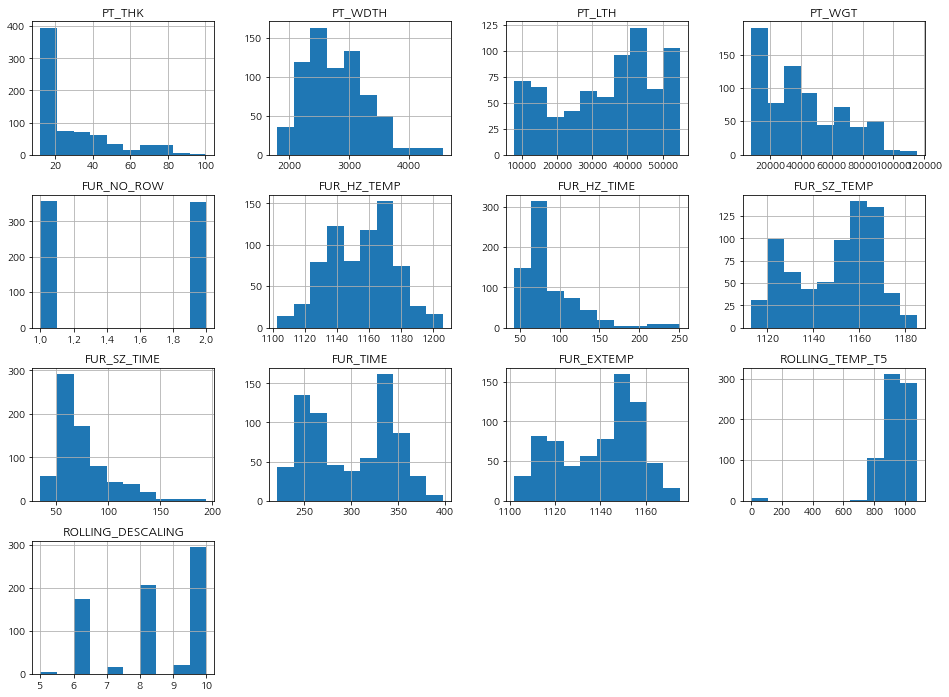

In [544]:
# 이상치 처리를 위한 그래프
df.hist(figsize = (16, 12))
plt.show()

#### 그래프를 확인한 결과 ROLLING_TEMP_T5의 분포가 정규분포를 따르지 않으므로 평균값으로 대체할 수 없다고 판단했다. 
#### 따라서 이상치인 0을 제거한 후 데이터 분석을 진행하겠다.

In [545]:
# 결측값은 없음
df.isnull().sum(axis=0)

PLATE_NO             0
ROLLING_DATE         0
SCALE                0
SPEC                 0
STEEL_KIND           0
PT_THK               0
PT_WDTH              0
PT_LTH               0
PT_WGT               0
FUR_NO               0
FUR_NO_ROW           0
FUR_HZ_TEMP          0
FUR_HZ_TIME          0
FUR_SZ_TEMP          0
FUR_SZ_TIME          0
FUR_TIME             0
FUR_EXTEMP           0
ROLLING_TEMP_T5      0
HSB                  0
ROLLING_DESCALING    0
WORK_GR              0
dtype: int64

## 2. 그래프 분석 및 통계적 가설검정

In [546]:
#histogram 함수
def fun_plot_hist(data, var):
    plt.hist(data[data["SCALE"] == "양품"][var], label = "양품", alpha = 0.5)
    plt.hist(data[data["SCALE"] == "불량"][var], label = "불량", alpha = 0.5)
    plt.legend()

In [547]:
#교차표 함수
def fun_print_crosstab(data, var):
    print(pd.crosstab(index = data["SCALE"], columns = data[var]))
    print()
    print(pd.crosstab(index = data["SCALE"], columns = data[var], normalize = "columns").round(3))

#교차표 생성
fun_print_crosstab(df, "FUR_NO")

FUR_NO  1호기  2호기  3호기
SCALE                
불량       73   69   88
양품      164  167  153

FUR_NO    1호기    2호기    3호기
SCALE                      
불량      0.308  0.292  0.365
양품      0.692  0.708  0.635


#### C0를 썼을때 불량이 많았다. --> 그러나 특정 종류의 철이 불량률이 높다고 해서 안쓸수가 없다. 그래서 분석하지 않겠다.

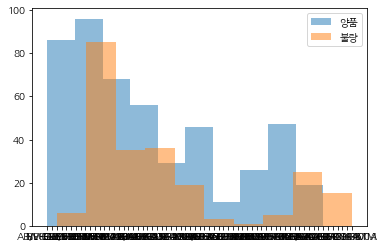

In [548]:
fun_plot_hist(df, 'SPEC')

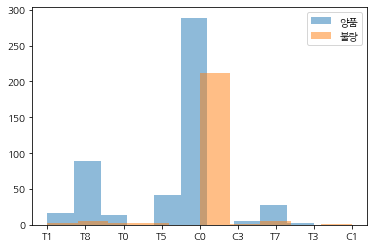

In [549]:
fun_plot_hist(df, 'STEEL_KIND')

#### 가열로 호기에 따라 불량률의 차이가 나지 않음

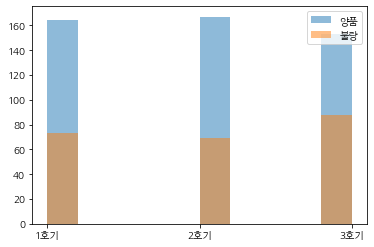

In [550]:
fun_plot_hist(df, 'FUR_NO')

#### 가열로 작업 순번에 따라 불량률의 차이가 나지 않음

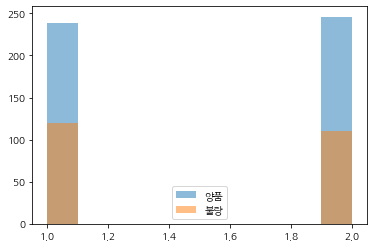

In [551]:
fun_plot_hist(df, 'FUR_NO_ROW')

#### 가열로 가열대 온도가 1200을 넘는 경우는 다 불량이었음.

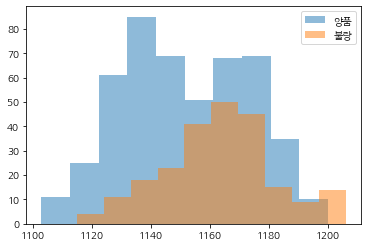

In [552]:
fun_plot_hist(df, 'FUR_HZ_TEMP')

#### 가열로 가열대 시간이 200분이 넘으면 모두 불량이었으며 약 70~110분정도는 불량률이 50%에 육박함.

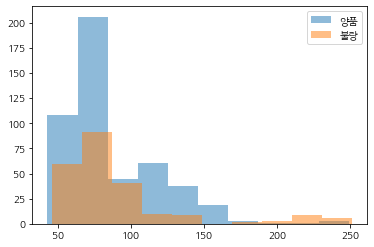

In [553]:
fun_plot_hist(df, 'FUR_HZ_TIME')

#### 가열로 가열대 시간이 45~55분 정도일때 불량률이 50퍼센트에 육박함.

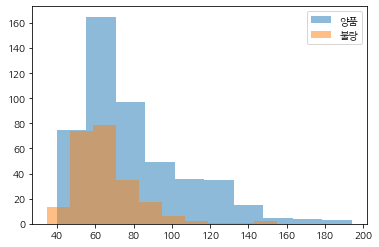

In [554]:
fun_plot_hist(df, 'FUR_SZ_TIME')

#### 가열로 균열대 온도가 1175도가 넘으면 불량률이 100%이고 1155도~1170도 사이는 불량률이 50% 이상임.

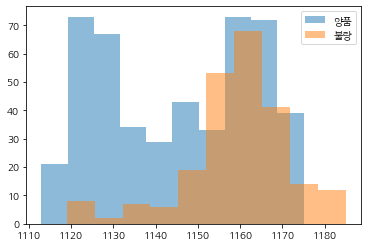

In [555]:
fun_plot_hist(df, 'FUR_SZ_TEMP')

#### 가열로 균열대 온도가 275도~ 325도일때, 375도이상일때 불량률이 50퍼 이상임.
#### 가열로 균열대 온도가 225도 미만일때 불량률이 100퍼센트임.

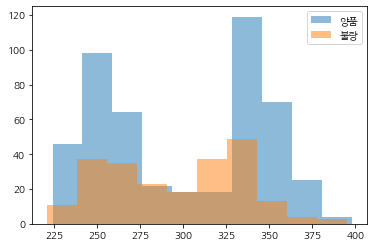

In [556]:
fun_plot_hist(df, 'FUR_TIME')

#### 추출온도가 1145도~1165도일때 불량률이 50% 정도 이며, 1165도 이상은 불량률이 100%임.

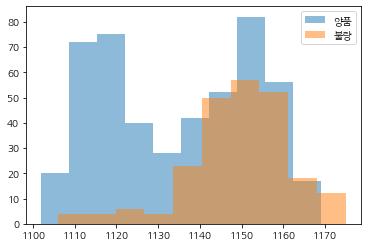

In [557]:
fun_plot_hist(df, 'FUR_EXTEMP')

#### 압연온도가 1000도 이상일때 불량률이 100퍼센트임

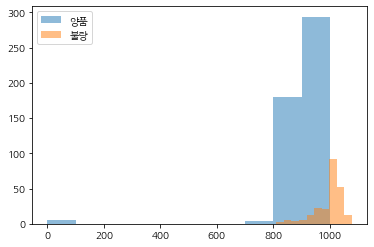

In [558]:
fun_plot_hist(df, 'ROLLING_TEMP_T5')

#### HSB를 미적용 했을때 불량률이 100퍼센트임

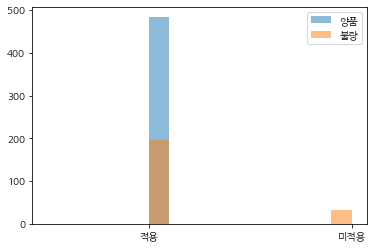

In [559]:
fun_plot_hist(df, 'HSB')

#### 압연 중 descaling 횟수가 5번, 7번, 9번일때는 불량률이 100%이고, 8번인 경우는 불량률이 50%에 육박함.

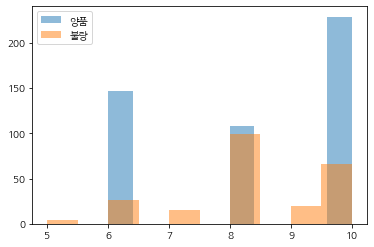

In [560]:
fun_plot_hist(df, 'ROLLING_DESCALING')

#### 작업조에 따라 불량률의 차이가 크게 보이지 않음

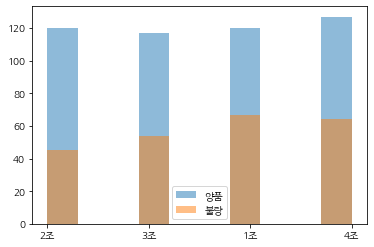

In [561]:
fun_plot_hist(df, 'WORK_GR')

### 간단한 모델링을 통한 주요인자 확인

## 의사결정나무

In [562]:
df_test = df.copy()

In [563]:
def bool_ch(pum):
    for x in range(len(pum)):
        if pum[:2] == 'AB':
            return 1
        elif pum[:2] == 'BV':
            return 2
        elif pum[:2] == 'CO':
            return 3
        elif pum[:2] == 'GL':
            return 4
        elif pum[:2] == 'JS':
            return 5
        elif pum[:2] == 'KR':
            return 6
        elif pum[:2] == 'KS':
            return 7
        elif pum[:2] == 'NV':
            return 8
        else:
            return 9

df_test['SPEC'] = df_test['SPEC'].apply(bool_ch)

def bool_ch(pum):
    for x in range(len(pum)):
        if pum == '양품':
            return 1
        else:
            return 0
        
df_test['SCALE'] = df_test['SCALE'].apply(bool_ch)

In [564]:
df_y = df_test['SCALE']
df_x = pd.get_dummies(df_test.drop('SCALE', axis = 1, inplace=False))

In [565]:
df_train_x, df_test_x, df_train_y, df_test_y = train_test_split(df_x, df_y, test_size=0.3)

In [566]:
tree_uncustomized = DTC()
tree_uncustomized.fit(df_train_x, df_train_y)

# df_train, df_test, df_train_y, df_test_y = train_test_split(df_x,df_y,test_size=0.3)
print('train data X size:',df_train_x.shape)
print('train data Y size:',df_train_y.shape)
print('test data X size:',df_test_x.shape)
print('test data Y size:',df_test_y.shape)

train data X size: (499, 1444)
train data Y size: (499,)
test data X size: (215, 1444)
test data Y size: (215,)


In [567]:
v_feature_name = df_train_x.columns

df_importance = pd.DataFrame()
df_importance["Feature"] = v_feature_name
df_importance["Importance"] = tree_uncustomized.feature_importances_

df_importance.sort_values("Importance", ascending=False, inplace = True)

df_importance.index=list(range(1444))
df_importance[:10]

,Feature,Importance
0,ROLLING_TEMP_T5,0.556191
1,HSB_적용,0.158503
2,FUR_SZ_TEMP,0.110952
3,ROLLING_DESCALING,0.033303
4,FUR_TIME,0.016934
5,ROLLING_DATE_2008-08-01:13:32:01,0.009203
6,PLATE_NO_PB563031,0.009150
7,PLATE_NO_PB563340,0.009096
8,ROLLING_DATE_2008-08-01:16:63:23,0.009043
9,ROLLING_DATE_2008-08-01:16:62:39,0.008991


### 랜덤포레스트

In [568]:
tree_uncustomized = RFC()
tree_uncustomized.fit(df_train_x, df_train_y)

print('train data 설명력: ', tree_uncustomized.score(df_train_x,df_train_y))
print('test data 설명력: ', tree_uncustomized.score(df_test_x,df_test_y))

train data 설명력:  1.0
test data 설명력:  0.9441860465116279


In [569]:
v_feature_name = df_train_x.columns

df_importance = pd.DataFrame()
df_importance["Feature"] = v_feature_name
df_importance["Importance"] = tree_uncustomized.feature_importances_

df_importance.sort_values("Importance", ascending=False, inplace = True)

df_importance.index=list(range(1444))
df_importance[:10]

,Feature,Importance
0,ROLLING_TEMP_T5,0.153236
1,FUR_EXTEMP,0.060528
2,FUR_SZ_TEMP,0.054800
3,PT_THK,0.052807
4,PT_WDTH,0.051953
5,ROLLING_DESCALING,0.046389
6,PT_LTH,0.037225
7,PT_WGT,0.035161
8,FUR_TIME,0.034207
9,FUR_HZ_TEMP,0.031900


### 그래디언트 부스팅

In [570]:
tree_uncustomized = GBC()
tree_uncustomized.fit(df_train_x, df_train_y)

print('train data 설명력: ', tree_uncustomized.score(df_train_x,df_train_y))
print('test data 설명력: ', tree_uncustomized.score(df_test_x,df_test_y))

train data 설명력:  1.0
test data 설명력:  0.9674418604651163


In [571]:
v_feature_name = df_train_x.columns

df_importance = pd.DataFrame()
df_importance["Feature"] = v_feature_name
df_importance["Importance"] = tree_uncustomized.feature_importances_

df_importance.sort_values("Importance", ascending=False, inplace = True)

df_importance.index=list(range(1444))
df_importance[:10]

,Feature,Importance
0,ROLLING_TEMP_T5,0.575965
1,FUR_SZ_TEMP,0.114936
2,HSB_미적용,0.092464
3,HSB_적용,0.070074
4,ROLLING_DESCALING,0.045526
5,FUR_TIME,0.013500
6,PT_THK,0.006482
7,PLATE_NO_PB563022,0.005546
8,ROLLING_DATE_2008-08-01:12:20:21,0.004216
9,ROLLING_DATE_2008-08-01:18:83:42,0.004190


### 그래프, 통계적 가설검정, 간단한 모델링 결과를 종합하여 FUR_HZ_TEMP, FUR_HZ_TIME, FUR_SZ_TEMP, FUR_SZ_TIME,  FURTIME, FUREXTRME, ROLLING_TEMP, ROLLING_DESCALING  를 주요 인자로 선정함.

## 3. 모델링

### 의사결정나무

In [573]:
df_y = df['SCALE']
df_x = df[['FUR_HZ_TEMP', 'FUR_HZ_TIME', 'FUR_SZ_TEMP', 'FUR_SZ_TIME', 'FUR_TIME', 'FUR_EXTEMP', 'ROLLING_TEMP_T5', 'ROLLING_DESCALING']] 

In [574]:
df_train_x, df_test_x, df_train_y, df_test_y = train_test_split(df_x,df_y,test_size=0.3)
print('train data X size:',df_train_x.shape)
print('train data Y size:',df_train_y.shape)
print('test data X size:',df_test_x.shape)
print('test data Y size:',df_test_y.shape)

train data X size: (499, 8)
train data Y size: (499,)
test data X size: (215, 8)
test data Y size: (215,)


In [575]:
train_accuracy = []; test_accuracy = []
para_depth = [depth for depth in range (1,11)]

for v_max_depth in para_depth:
    tree = DTC(max_depth = v_max_depth, random_state=1234)
    tree.fit(df_train_x, df_train_y)
    train_accuracy.append(tree.score(df_train_x,df_train_y))
    test_accuracy.append(tree.score(df_test_x,df_test_y))

df_accuracy_depth = pd.DataFrame()
df_accuracy_depth['Depth'] = para_depth
df_accuracy_depth['TrainAccuracy'] = train_accuracy
df_accuracy_depth['TestAccuracy'] = test_accuracy

In [576]:
df_accuracy_depth.round(3)

,Depth,TrainAccuracy,TestAccuracy
0,1,0.884,0.907
1,2,0.922,0.921
2,3,0.928,0.926
3,4,0.928,0.926
4,5,0.936,0.940
5,6,0.942,0.935
6,7,0.942,0.935
7,8,0.948,0.926
8,9,0.958,0.926
9,10,0.970,0.907


#### train/test 데이터의 성능 변화를 고려하여 깊이를 6으로 선정

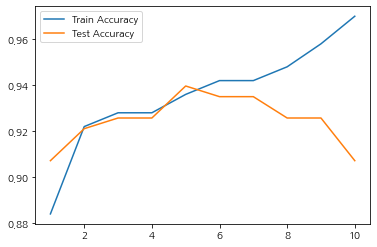

In [577]:
plt.plot(para_depth, train_accuracy, linestyle = "-",label = 'Train Accuracy')
plt.plot(para_depth, test_accuracy, linestyle = "-",label = 'Test Accuracy')
plt.legend()

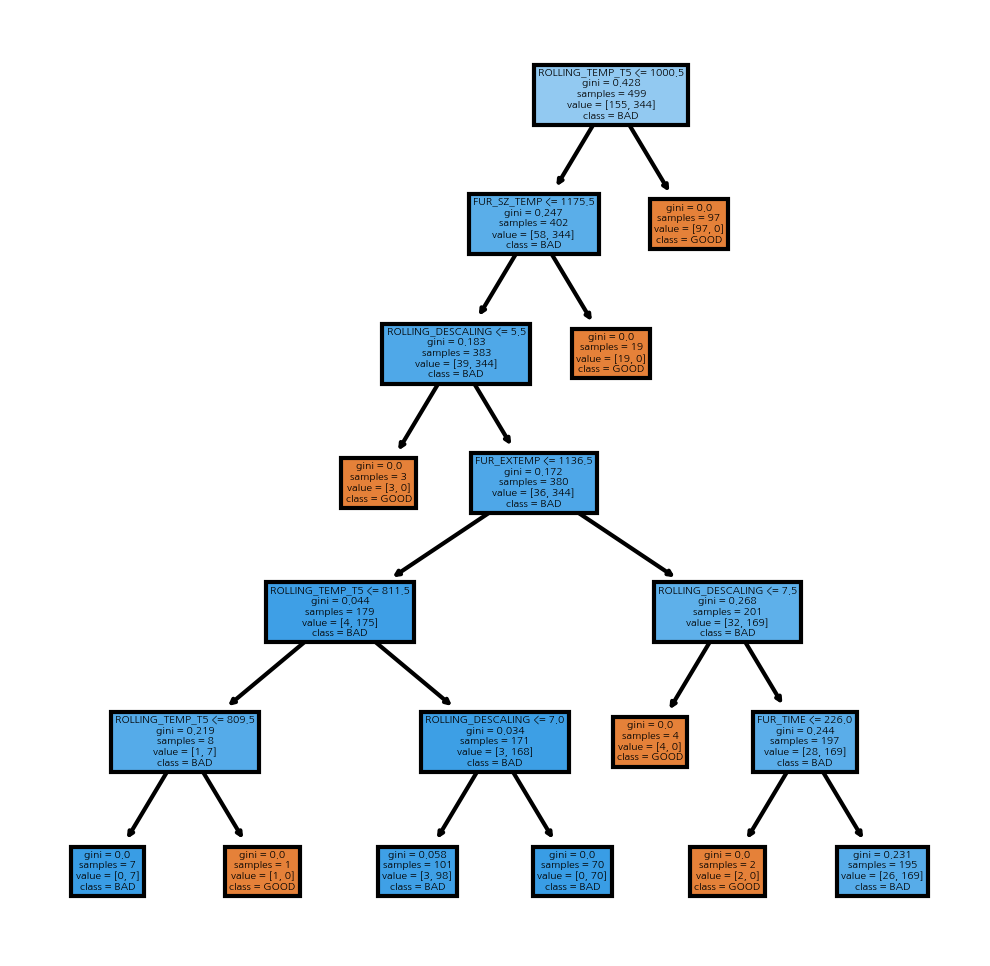

In [578]:
v_feature_name = df_train_x.columns

tree_low = DTC(max_depth = 6, random_state=1234)
tree_low.fit(df_train_x,df_train_y)

fig, axes = plt.subplots(nrows = 1, ncols = 1, figsize = (4, 4), dpi=300)
plot_tree(tree_low, class_names = ['GOOD', 'BAD'], feature_names = v_feature_name,impurity = True, filled=True)
plt.show()

In [579]:
train_accuracy = [];test_accuracy=[]
para_split = [n_split * 10 for n_split in range(1,11)]

for v_min_samples_split in para_split:
    tree = DTC(min_samples_split = v_min_samples_split, max_depth = 6)
    tree.fit(df_train_x,df_train_y)
    train_accuracy.append(tree.score(df_train_x,df_train_y))
    test_accuracy.append(tree.score(df_test_x,df_test_y))
    
df_accuracy_split = pd.DataFrame()
df_accuracy_split['MinSamplesSplit'] = para_split
df_accuracy_split['TrainAccuracy'] = train_accuracy
df_accuracy_split["TestAccuracy"] = test_accuracy
df_accuracy_split.round(3)

,MinSamplesSplit,TrainAccuracy,TestAccuracy
0,10,0.94,0.94
1,20,0.94,0.94
2,30,0.94,0.94
3,40,0.94,0.94
4,50,0.94,0.94
5,60,0.94,0.94
6,70,0.94,0.94
7,80,0.94,0.94
8,90,0.94,0.94
9,100,0.94,0.94


#### min split split에 따라 값이 변하지 않으므로 값을 설정하지 않겠음

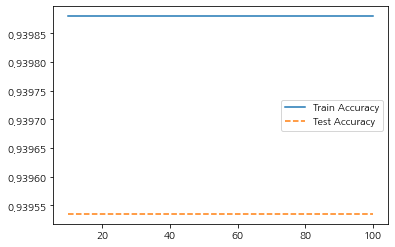

In [580]:
plt.plot(para_split, train_accuracy, linestyle = "-",label = 'Train Accuracy')
plt.plot(para_split, test_accuracy, linestyle = "--",label = 'Test Accuracy')
plt.legend()

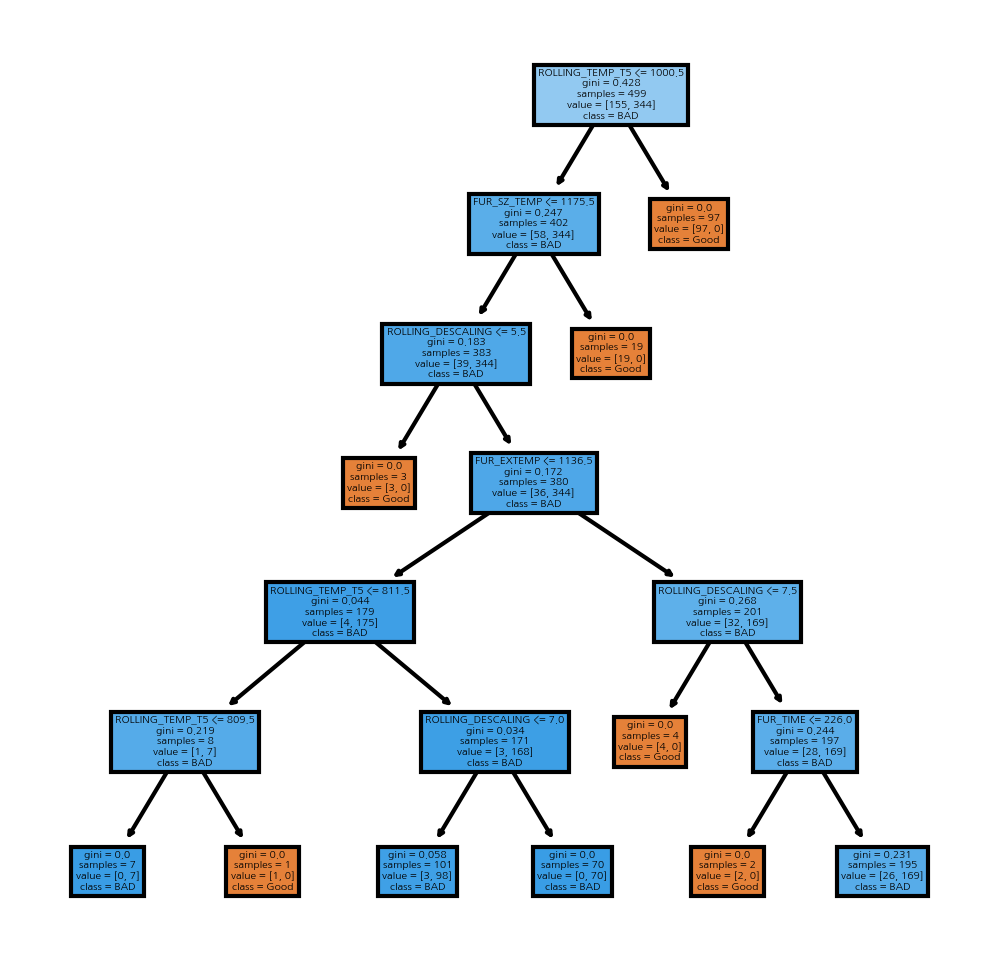

In [581]:
tree_low = DTC(max_depth = 6, random_state=1234)
tree_low.fit(df_train_x,df_train_y)

export_graphviz(tree_low, out_file="tree_low.dot", class_names = ['Good','Bad'], feature_names = v_feature_name ,impurity = True, filled=True)

fig, axes = plt.subplots(nrows = 1, ncols = 1, figsize = (4, 4), dpi=300)
plot_tree(tree_low, class_names = ['Good', 'BAD'], feature_names = v_feature_name,impurity = True, filled=True)
plt.show()

### 잎사귀 노드의 최소 자료 수

In [582]:
train_accuracy = [];test_accuracy=[]
para_leaf = [n_split * 2 for n_split in range(1,11)]

for v_min_samples_leaf in para_split:
    tree = DTC(min_samples_leaf = v_min_samples_leaf, max_depth = 6)
    tree.fit(df_train_x,df_train_y)
    train_accuracy.append(tree.score(df_train_x,df_train_y))
    test_accuracy.append(tree.score(df_test_x,df_test_y))
    
df_accuracy_leaf = pd.DataFrame()
df_accuracy_leaf['MinSamplesSplit'] = para_leaf
df_accuracy_leaf['TrainAccuracy'] = train_accuracy
df_accuracy_leaf["TestAccuracy"] = test_accuracy
df_accuracy_leaf.round(3)

,MinSamplesSplit,TrainAccuracy,TestAccuracy
0,2,0.944,0.935
1,4,0.916,0.907
2,6,0.900,0.898
3,8,0.896,0.893
4,10,0.886,0.870
5,12,0.884,0.907
6,14,0.884,0.907
7,16,0.884,0.907
8,18,0.884,0.907
9,20,0.878,0.898


#### 잎사귀 노드의 최소 자료 수를 12로 선택

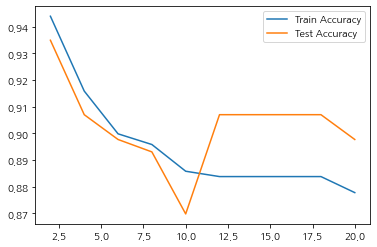

In [583]:
plt.plot(para_leaf, train_accuracy, linestyle = "-",label = 'Train Accuracy')
plt.plot(para_leaf, test_accuracy, linestyle = "-",label = 'Test Accuracy')
plt.legend()

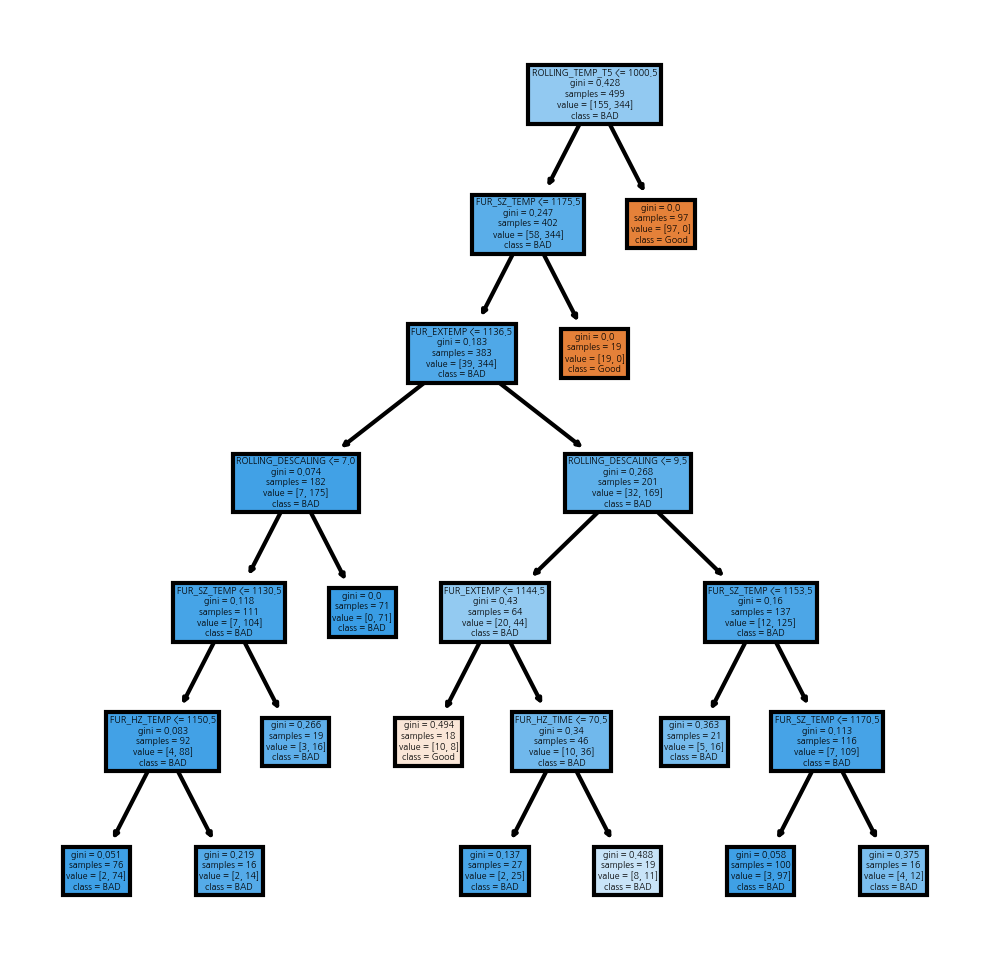

In [584]:
tree_low = DTC(max_depth = 6, min_samples_leaf=12)
tree_low.fit(df_train_x,df_train_y)

export_graphviz(tree_low, out_file="tree_low.dot", class_names = ['Good','Bad'], feature_names = v_feature_name ,impurity = True, filled=True)

fig, axes = plt.subplots(nrows = 1, ncols = 1, figsize = (4, 4), dpi=300)
plot_tree(tree_low, class_names = ['Good', 'BAD'], feature_names = v_feature_name,impurity = True, filled=True)
plt.show()

In [585]:
tree_final = DTC(min_samples_leaf=12, max_depth = 6)
tree_final.fit(df_train_x,df_train_y)

DecisionTreeClassifier(max_depth=6, min_samples_leaf=12)

In [586]:
y_pred = tree_final.predict(df_test_x)
print("Accuracy: {0:.3f}\n".format(tree_final.score(df_test_x, df_test_y)))
print("Confusion matrix: \n{}".format(confusion_matrix(df_test_y, y_pred)))

print(classification_report(df_test_y, y_pred, digits=3))

Accuracy: 0.916

Confusion matrix: 
[[ 59  16]
 [  2 138]]
              precision    recall  f1-score   support

          불량      0.967     0.787     0.868        75
          양품      0.896     0.986     0.939       140

    accuracy                          0.916       215
   macro avg      0.932     0.886     0.903       215
weighted avg      0.921     0.916     0.914       215



In [587]:
# tree.feature_importances_로 설명변수 중요도 확인 및 테이블로 저장
df_importance = pd.DataFrame()
df_importance["Feature"] = v_feature_name
df_importance["Importance"] = tree_final.feature_importances_

# df_feature_importance의 테이블을 중요도별로 정렬
df_importance.sort_values("Importance", ascending = False, inplace = True)
df_importance.round(3)

,Feature,Importance
6,ROLLING_TEMP_T5,0.715
2,FUR_SZ_TEMP,0.201
5,FUR_EXTEMP,0.036
7,ROLLING_DESCALING,0.030
1,FUR_HZ_TIME,0.017
0,FUR_HZ_TEMP,0.002
3,FUR_SZ_TIME,0.000
4,FUR_TIME,0.000


### 랜덤포레스트

In [588]:
train_accuracy =[]
test_accuracy = []
para_n_tree = [n_tree * 10 for n_tree in range(1,20)]


for v_n_estimators in para_n_tree:
    rf=RFC(n_estimators=v_n_estimators)
    rf.fit(df_train_x, df_train_y)
    train_accuracy.append(rf.score(df_train_x,df_train_y))
    test_accuracy.append(rf.score(df_test_x, df_test_y))
    
df_accuracy_n = pd.DataFrame()
df_accuracy_n["n_estimators"] = para_n_tree
df_accuracy_n["TrainAccuracy"] = train_accuracy
df_accuracy_n["TestAccuracy"] = test_accuracy

In [589]:
df_accuracy_n.round(3)

,n_estimators,TrainAccuracy,TestAccuracy
0,10,0.998,0.907
1,20,1.000,0.935
2,30,0.998,0.926
3,40,1.000,0.926
4,50,0.998,0.930
5,60,1.000,0.916
6,70,1.000,0.930
7,80,1.000,0.926
8,90,1.000,0.916
9,100,0.998,0.935


#### train test 데이터의 성능 변화를 고려해 20 선택

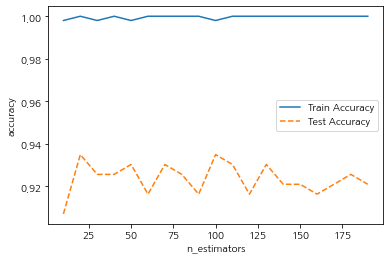

In [590]:
plt.plot(para_n_tree, train_accuracy, linestyle = "-",label = 'Train Accuracy')
plt.plot(para_n_tree, test_accuracy, linestyle = "--",label = 'Test Accuracy')
plt.xlabel("n_estimators")
plt.ylabel("accuracy")
plt.legend()

In [591]:
oob_error = []

for v_n_estimator in range(1,151):
    rf = RFC(n_estimators = v_n_estimators, oob_score = True)
    rf.fit(df_train_x, df_train_y)
    oob_error.append(1 - rf.oob_score_)

#### obb error가 없으므로 그대로 20 선택

Text(0, 0.5, 'n_estimators')

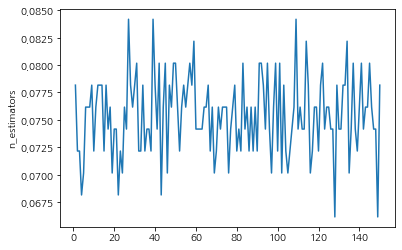

In [592]:
plt.plot(range(1,151),oob_error)
plt.ylabel("oob error")
plt.ylabel("n_estimators")

In [593]:
train_accuracy = []; test_accuracy = []
para_depth = [depth for depth in range (1,15)]

for v_max_depth in para_depth:
    rf = RFC(max_depth = v_max_depth, n_estimators = 20)
    rf.fit(df_train_x, df_train_y)
    train_accuracy.append(rf.score(df_train_x,df_train_y))
    test_accuracy.append(rf.score(df_test_x,df_test_y))

df_accuracy_depth = pd.DataFrame()
df_accuracy_depth['Depth'] = para_depth
df_accuracy_depth['TrainAccuracy'] = train_accuracy
df_accuracy_depth['TestAccuracy'] = test_accuracy

In [594]:
df_accuracy_depth.round(3)

,Depth,TrainAccuracy,TestAccuracy
0,1,0.848,0.856
1,2,0.888,0.907
2,3,0.922,0.921
3,4,0.924,0.916
4,5,0.934,0.921
5,6,0.936,0.921
6,7,0.968,0.935
7,8,0.974,0.930
8,9,0.976,0.921
9,10,0.990,0.921


#### train, test 정확도를 고려하여 깊이를 7로 선정

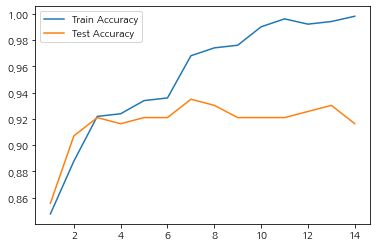

In [595]:
plt.plot(para_depth, train_accuracy, linestyle = "-",label = 'Train Accuracy')
plt.plot(para_depth, test_accuracy, linestyle = "-",label = 'Test Accuracy')
plt.legend()

In [596]:
train_accuracy = [];test_accuracy=[]
para_split = [n_split * 10 for n_split in range(1,11)]

for v_min_samples_split in para_split:
    tree = RFC(min_samples_split = v_min_samples_split, max_depth = 7, n_estimators = 20)
    tree.fit(df_train_x,df_train_y)
    train_accuracy.append(tree.score(df_train_x,df_train_y))
    test_accuracy.append(tree.score(df_test_x,df_test_y))
    
df_accuracy_split = pd.DataFrame()
df_accuracy_split['MinSamplesSplit'] = para_split
df_accuracy_split['TrainAccuracy'] = train_accuracy
df_accuracy_split["TestAccuracy"] = test_accuracy
df_accuracy_split.round(3)

,MinSamplesSplit,TrainAccuracy,TestAccuracy
0,10,0.938,0.921
1,20,0.940,0.926
2,30,0.932,0.916
3,40,0.928,0.921
4,50,0.940,0.926
5,60,0.924,0.926
6,70,0.926,0.916
7,80,0.922,0.921
8,90,0.938,0.930
9,100,0.924,0.926


#### 정확도를 위해 min samples split를 90으로 설정

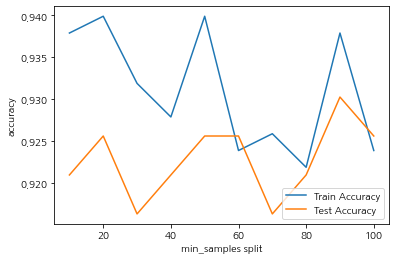

In [597]:
plt.plot(para_split, train_accuracy, linestyle = "-",label = 'Train Accuracy')
plt.plot(para_split, test_accuracy, linestyle = "-",label = 'Test Accuracy')
plt.xlabel('min_samples split'); plt.ylabel('accuracy')
plt.legend()

In [598]:
train_accuracy = [];test_accuracy=[]
para_leaf = [n_leaf * 1 for n_leaf in range(1,11)]

for v_min_samples_leaf in para_leaf:
    tree = RFC(min_samples_leaf = v_min_samples_leaf, max_depth = 7,min_samples_split = 90, n_estimators = 20)
    tree.fit(df_train_x,df_train_y)
    train_accuracy.append(tree.score(df_train_x,df_train_y))
    test_accuracy.append(tree.score(df_test_x,df_test_y))
    
df_accuracy_leaf = pd.DataFrame()
df_accuracy_leaf['MinSamplesSplit'] = para_leaf
df_accuracy_leaf['TrainAccuracy'] = train_accuracy
df_accuracy_leaf["TestAccuracy"] = test_accuracy
df_accuracy_leaf.round(3)

,MinSamplesSplit,TrainAccuracy,TestAccuracy
0,1,0.932,0.926
1,2,0.926,0.921
2,3,0.918,0.912
3,4,0.920,0.921
4,5,0.920,0.916
5,6,0.924,0.921
6,7,0.924,0.916
7,8,0.926,0.921
8,9,0.914,0.921
9,10,0.918,0.912


#### test, train 성능을 위해 min_samples_leaf를 1개로 선정

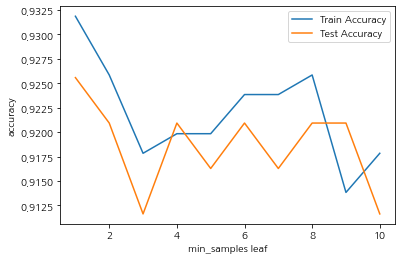

In [599]:
plt.plot(para_leaf, train_accuracy, linestyle = "-",label = 'Train Accuracy')
plt.plot(para_leaf, test_accuracy, linestyle = "-",label = 'Test Accuracy')
plt.xlabel('min_samples leaf'); plt.ylabel('accuracy')
plt.legend()

In [600]:
tree_final = RFC(min_samples_leaf=1,max_depth = 7,min_samples_split = 90, n_estimators = 20)
tree_final.fit(df_train_x,df_train_y)
y_pred = tree_final.predict(df_test_x)
print("Accuracy: {0:.3f}\n".format(tree_final.score(df_test_x, df_test_y)))
print("Confusion matrix: \n{}".format(confusion_matrix(df_test_y, y_pred)))

print(classification_report(df_test_y, y_pred, digits=3))

Accuracy: 0.916

Confusion matrix: 
[[ 58  17]
 [  1 139]]
              precision    recall  f1-score   support

          불량      0.983     0.773     0.866        75
          양품      0.891     0.993     0.939       140

    accuracy                          0.916       215
   macro avg      0.937     0.883     0.902       215
weighted avg      0.923     0.916     0.914       215



In [601]:
# tree.feature_importances_로 설명변수 중요도 확인 및 테이블로 저장
df_importance = pd.DataFrame()
df_importance["Feature"] = v_feature_name
df_importance["Importance"] = tree_final.feature_importances_

# df_feature_importance의 테이블을 중요도별로 정렬
df_importance.sort_values("Importance", ascending = False, inplace = True)
df_importance.round(3)

,Feature,Importance
6,ROLLING_TEMP_T5,0.600
5,FUR_EXTEMP,0.140
2,FUR_SZ_TEMP,0.073
0,FUR_HZ_TEMP,0.061
4,FUR_TIME,0.044
3,FUR_SZ_TIME,0.032
7,ROLLING_DESCALING,0.025
1,FUR_HZ_TIME,0.024


### 인공신경망

#### scale 변환

In [626]:
v_feature_name = df_train_x.columns

scaler = StandardScaler()
df_scaled = scaler.fit_transform(df_x)
df_scaled = pd.DataFrame(df_scaled, columns=v_feature_name)
df_scaled.head()

,FUR_HZ_TEMP,FUR_HZ_TIME,FUR_SZ_TEMP,FUR_SZ_TIME,FUR_TIME,FUR_EXTEMP,ROLLING_TEMP_T5,ROLLING_DESCALING
0,-0.546801,0.762854,-0.959385,-0.618767,-0.402605,-0.825284,-0.002283,-0.205418
1,-0.546801,0.927899,-0.845123,-0.849572,-0.380586,-1.106175,0.025505,-0.205418
2,-1.264917,0.762854,-1.644957,-0.772637,-0.402605,-1.892670,-0.419101,-0.205418
3,-0.163806,1.010422,-1.302171,-0.272559,0.346046,-1.499422,-0.456152,-0.205418
4,-0.738298,1.257990,-1.245040,-1.041910,0.302008,-1.218532,-0.567303,-0.205418


In [627]:
df_scaled_train_x, df_scaled_test_x = train_test_split(df_scaled, test_size = 0.3)
print('train data X size:{}'.format(df_scaled_train_x.shape))
print('test data X size:{}'.format(df_scaled_test_x.shape))

train data X size:(499, 8)
test data X size:(215, 8)


In [628]:
nn_scaled = MLPClassifier()
nn_scaled.fit(df_scaled_train_x, df_train_y)

print('Accuracy on training set:{:.3f}'.format(nn_scaled.score(df_scaled_train_x,df_train_y)))
print('Accuracy on test set:{:.3f}'.format(nn_scaled.score(df_scaled_test_x,df_test_y)))

Accuracy on training set:0.713
Accuracy on test set:0.656


C:\Users\jwkan\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


In [631]:
train_accuracy = []; test_accuracy = []
para_hidden = [2 * hidden for hidden in range(5,30)]

for v_hidden in para_hidden:
    nn=MLPClassifier(hidden_layer_sizes=(v_hidden,v_hidden))
    nn.fit(df_scaled_train_x,df_train_y)
    train_accuracy.append(nn.score(df_scaled_train_x,df_train_y))
    test_accuracy.append(nn.score(df_scaled_test_x,df_test_y))
    
df_accuracy_hidden = pd.DataFrame()
df_accuracy_hidden["HiddenLayer"] = para_hidden
df_accuracy_hidden["TrainAccuracy"] = train_accuracy
df_accuracy_hidden["TestAccuracy"] = test_accuracy

C:\Users\jwkan\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\jwkan\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\jwkan\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\jwkan\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\jwkan\anaconda3\lib\site-packages\sklearn\neural_network\_multi

In [632]:
df_accuracy_hidden.round(3)

,HiddenLayer,TrainAccuracy,TestAccuracy
0,10,0.695,0.656
1,12,0.697,0.656
2,14,0.707,0.656
3,16,0.703,0.665
4,18,0.709,0.633
5,20,0.727,0.651
6,22,0.723,0.660
7,24,0.731,0.656
8,26,0.729,0.674
9,28,0.737,0.628


#### train, test accuracy를 고려하여 은닉층을 25개로 선정

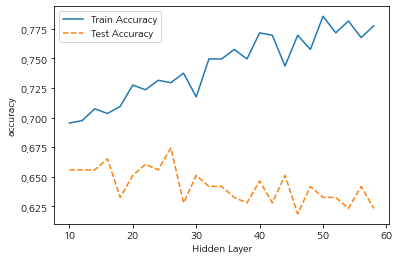

In [633]:
plt.plot(para_hidden,train_accuracy,linestyle="-",label = "Train Accuracy")
plt.plot(para_hidden,test_accuracy,linestyle="--",label = "Test Accuracy")
plt.ylabel("accuracy");plt.xlabel("Hidden Layer")
plt.legend()

In [634]:
train_accuracy = []; test_accuracy = []
para_function = ['logistic', 'tanh', 'relu']

for v_function in para_function:
    nn=MLPClassifier(activation = v_function,hidden_layer_sizes=(25,25))
    nn.fit(df_scaled_train_x,df_train_y)
    train_accuracy.append(nn.score(df_scaled_train_x,df_train_y))
    test_accuracy.append(nn.score(df_scaled_test_x,df_test_y))
    
df_accuracy_function = pd.DataFrame()
df_accuracy_function["ActivationFunction"] = para_function
df_accuracy_function["TrainAccuracy"] = train_accuracy
df_accuracy_function["TestAccuracy"] = test_accuracy

C:\Users\jwkan\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\jwkan\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


In [635]:
df_accuracy_function.round(3)

,ActivationFunction,TrainAccuracy,TestAccuracy
0,logistic,0.689,0.651
1,tanh,0.703,0.651
2,relu,0.717,0.670


#### relu가 가장 test accuracy가 높으므로 relu를 사용.

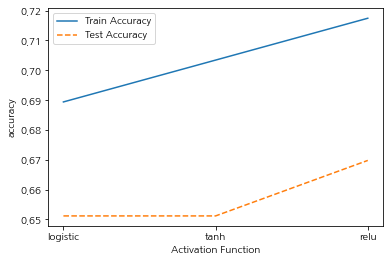

In [637]:
plt.plot(para_function,train_accuracy,linestyle="-",label = "Train Accuracy")
plt.plot(para_function,test_accuracy,linestyle="--",label = "Test Accuracy")
plt.ylabel("accuracy");plt.xlabel("Activation Function")
plt.legend()

In [642]:
train_accuracy = []; test_accuracy = []
para_solver = ['lbfgs', 'sgd', 'adam']

for v_solver in para_solver:
    nn=MLPClassifier(solver= v_solver, activation ='logistic',hidden_layer_sizes=(25,25))
    nn.fit(df_scaled_train_x,df_train_y)
    train_accuracy.append(nn.score(df_scaled_train_x,df_train_y))
    test_accuracy.append(nn.score(df_scaled_test_x,df_test_y))
    
df_accuracy_solver = pd.DataFrame()
df_accuracy_solver["ActivationFunction"] = para_solver
df_accuracy_solver["TrainAccuracy"] = train_accuracy
df_accuracy_solver["TestAccuracy"] = test_accuracy
df_accuracy_solver.round(3)

C:\Users\jwkan\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


,ActivationFunction,TrainAccuracy,TestAccuracy
0,lbfgs,0.886,0.558
1,sgd,0.689,0.651
2,adam,0.689,0.651


#### adam이 test accuracy가 가장 높으므로 adam 선택

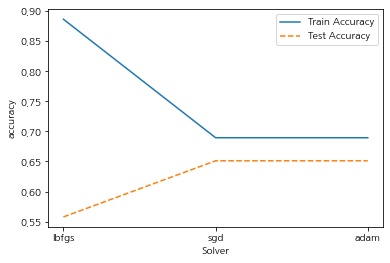

In [643]:
plt.plot(para_solver,train_accuracy,linestyle="-",label = "Train Accuracy")
plt.plot(para_solver,test_accuracy,linestyle="--",label = "Test Accuracy")
plt.ylabel("accuracy");plt.xlabel("Solver")
plt.legend()

In [644]:
train_accuracy = []; test_accuracy = []
para_batch = [20 * batch for batch in range(1, 10)]

for v_batch in para_batch:
    nn=MLPClassifier(batch_size= v_batch, solver = 'adam', activation = 'relu',hidden_layer_sizes=(25,25))
    nn.fit(df_scaled_train_x,df_train_y)
    train_accuracy.append(nn.score(df_scaled_train_x,df_train_y))
    test_accuracy.append(nn.score(df_scaled_test_x,df_test_y))
    
df_accuracy_batch = pd.DataFrame()
df_accuracy_batch["MiniBatch"] = para_batch
df_accuracy_batch["TrainAccuracy"] = train_accuracy
df_accuracy_batch["TestAccuracy"] = test_accuracy
df_accuracy_batch.round(3)

C:\Users\jwkan\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\jwkan\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\jwkan\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\jwkan\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\jwkan\anaconda3\lib\site-packages\sklearn\neural_network\_multi

,MiniBatch,TrainAccuracy,TestAccuracy
0,20,0.784,0.609
1,40,0.770,0.619
2,60,0.766,0.595
3,80,0.756,0.642
4,100,0.752,0.647
5,120,0.743,0.656
6,140,0.745,0.619
7,160,0.723,0.651
8,180,0.741,0.637


#### batch size를 120으로 선정

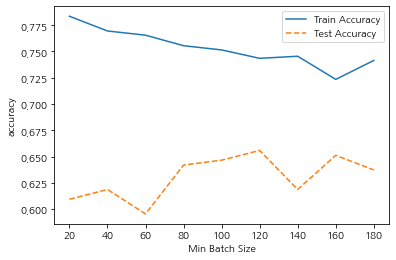

In [645]:
plt.plot(para_batch,train_accuracy,linestyle="-",label = "Train Accuracy")
plt.plot(para_batch,test_accuracy,linestyle="--",label = "Test Accuracy")
plt.ylabel("accuracy");plt.xlabel("Min Batch Size")
plt.legend()

In [650]:
nn_final = MLPClassifier(hidden_layer_sizes = (25, 25), activation = 'relu', solver ='adam', batch_size = 120)
nn_final.fit(df_scaled_train_x, df_train_y)
y_pred = nn_final.predict(df_scaled_test_x)

print('Accuracy on training set:{:.3f}'.format(nn_final.score(df_scaled_train_x,df_train_y)))
print('Accuracy on test set:{:.3f}\n'.format(nn_final.score(df_scaled_test_x,df_test_y)))
print('confusion matrix:\n{}'.format(confusion_matrix(df_test_y,y_pred)))
print(classification_report(df_test_y, y_pred, digits=3))

Accuracy on training set:0.727
Accuracy on test set:0.647

confusion matrix:
[[  9  66]
 [ 10 130]]
              precision    recall  f1-score   support

          불량      0.474     0.120     0.191        75
          양품      0.663     0.929     0.774       140

    accuracy                          0.647       215
   macro avg      0.568     0.524     0.483       215
weighted avg      0.597     0.647     0.571       215



C:\Users\jwkan\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


## 4. 모델 평가 (3가지 모델의 성능을 비교)

In [791]:
model = ['DecisionTree', 'RandomForest','NeuralNet']

train_accuracy = []; test_accuracy = []
model_auc = []

model_precision = []; model_recall = []
model_f1_score = []

In [792]:
s=[]
for x in pd.Series(df_y):
    if x=='양품':
        s.append(1)
    else:
        s.append(0)
df_final_y = pd.Series(s)

In [793]:
df_train_x, df_test_x , df_train_y, df_test_y = train_test_split(df_x, df_final_y, test_size = 0.3,
                                    random_state = 1234)

print('train data X size :{}'.format(df_train_x.shape))
print('train data Y size :{}'.format(df_train_y.shape))
print('test data X size :{}'.format(df_test_x.shape))
print('test data X size :{}'.format(df_test_y.shape))

train data X size :(499, 8)
train data Y size :(499,)
test data X size :(215, 8)
test data X size :(215,)


In [794]:
dt_model = DTC(max_depth = 6, min_samples_leaf = 12)
dt_model.fit(df_train_x, df_train_y)

train_accuracy.append(dt_model.score(df_train_x, df_train_y))
test_accuracy.append(dt_model.score(df_test_x, df_test_y))

y_pred = dt_model.predict(df_test_x)

fpr,tpr,thresholds = roc_curve(df_test_y, y_pred)
roc_auc =auc(fpr,tpr)

model_auc.append(roc_auc)

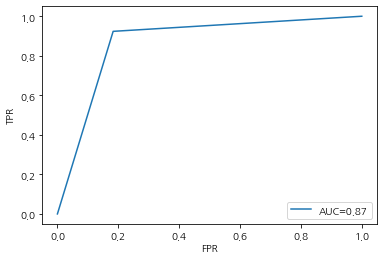

In [795]:
plt.plot(fpr,tpr,label='AUC=%0.2f'%roc_auc)
plt.legend(loc='lower right')
plt.ylabel('TPR')
plt.xlabel('FPR')
plt.show()

In [796]:
model_precision.append(precision_score(df_test_y, y_pred))
model_recall.append(recall_score(df_test_y, y_pred))

model_f1_score.append(f1_score(df_test_y, y_pred))

In [798]:
rf_model= RFC(min_samples_leaf=1,
                                max_depth=7,
                                n_estimators=20, min_samples_split = 90)
rf_model.fit(df_train_x, df_train_y)

train_accuracy.append(rf_model.score(df_train_x,df_train_y))
test_accuracy.append(rf_model.score(df_test_x,df_test_y))

y_pred = rf_model.predict(df_test_x)

fpr,tpr,thresholds = roc_curve(df_test_y, y_pred)

model_auc.append(roc_auc)


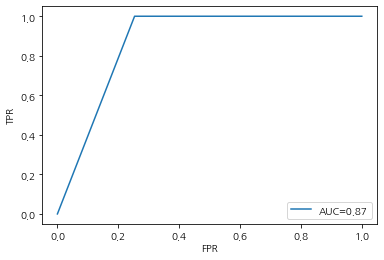

In [799]:
plt.plot(fpr,tpr,label='AUC=%0.2f'%roc_auc)
plt.legend(loc='lower right')
plt.ylabel('TPR')
plt.xlabel('FPR')
plt.show()


In [800]:
model_precision.append(precision_score(df_test_y,y_pred))
model_recall.append(recall_score(df_test_y,y_pred))

model_f1_score.append(f1_score(df_test_y,y_pred))

In [801]:
#모델생성
nn_model = MLPClassifier(hidden_layer_sizes = (25,25), activation = "relu", solver = "adam", batch_size = 120)
nn_model.fit(df_scaled_train_x, df_train_y)
#train 정확도
train_accuracy.append(nn_model.score(df_scaled_train_x, df_train_y))
#test 정확도
test_accuracy.append(nn_model.score(df_scaled_test_x,df_test_y))
#예측값
y_pred = nn_model.predict(df_scaled_test_x)
#roc_curve(실제값, 예측값)
fpr,tpr,thresholds = roc_curve(df_test_y,y_pred)
roc_auc = auc(fpr,tpr)
#auc저장
model_auc.append(roc_auc)

C:\Users\jwkan\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


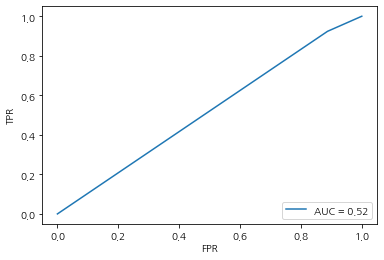

In [802]:
#roc_curve그리기, label에 auc표시(소수점 두자리)
plt.plot(fpr,tpr,label = "AUC = %0.2f"%roc_auc)
plt.legend(loc = "lower right")
plt.ylabel("TPR");plt.xlabel("FPR")
plt.show()

In [803]:
#precision, recall score
model_precision.append(precision_score(df_test_y, y_pred))
model_recall.append(recall_score(df_test_y, y_pred))
#f1 score
model_f1_score.append(f1_score(df_test_y, y_pred))

#### 셋 중 인공신경망의 성능이 가장 떨어지는 것을 확인할 수 있었음.

In [804]:
#모델별 평과 결과
df_eval = pd.DataFrame(index = model)
df_eval["TrainAccuracy"]=train_accuracy
df_eval["TestAccuracy"]=test_accuracy
df_eval["AUC"] = model_auc
df_eval["Precision"] = model_precision
df_eval["Recall"] = model_recall
df_eval["F1Score"]=model_f1_score
df_eval.round(3)

,TrainAccuracy,TestAccuracy,AUC,Precision,Recall,F1Score
DecisionTree,0.924,0.888,0.870,0.911,0.924,0.917
RandomForest,0.930,0.916,0.870,0.889,1.000,0.941
NeuralNet,0.721,0.656,0.518,0.679,0.924,0.782
